# <center>Using Large Language Models</center>

In this notebook we will demonstrate a new means of solving a common analysis/ data science task: understanding and labeling text. The tasks of summarizing and labeling texts are present in many analyst tasks and are an area where there has been an explosion of recent work in AI on. For this notebook, we are going to be leveraging some of the recent work in [Large Language Models (LLMs)](https://machinelearningmastery.com/what-are-large-language-models/) to solve these ML challenges. 

For this notebook, we will cover the following:
1. Installing packages and setting up the environment
2. Creating a data set
3. Summarizing and describing a corpus of text
4. Zero-shot text labeling
5. Using Prompt Engineering for more complex analyses of text data

----Addendum Section-----

6. Additional ways to summarize and describe text

# 1. Import neccessary Packages and Set up the Environment
- import neccessary packages, most especially [HuggingFace](https://huggingface.co/), Torch, and [LangChain](https://python.langchain.com/en/latest/index.html)
- we will also import and install Google's API in order to get some data related to YouTube Comments
- finally, we will set up any OpenAI keys for demonstrating working with API-based LLMs, like GPT.

In [ ]:
! pip install google-api-python-client
! pip install langchain --user
! pip install openai --user
! pip install bertopic
# The following are for getting certain LLMs to work
! pip install einops
! pip install tiktoken

In [207]:
import os, re, numpy as np, pandas as pd
from collections import Counter
from scipy import stats
from hdbscan import HDBSCAN
import umap
import openai
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import LangChain
from bertopic.representation import TextGeneration

from sentence_transformers  import SentenceTransformer
from transformers import pipeline
import torch

from googleapiclient.discovery import build

from langchain import OpenAI, PromptTemplate, LLMChain, HuggingFacePipeline, FewShotPromptTemplate
from langchain.llms import AzureOpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.chains.question_answering import load_qa_chain
from langchain.docstore.document import Document
from langchain.chains.mapreduce import MapReduceChain
from langchain.text_splitter import RecursiveCharacterTextSplitter

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [195]:
# import OpenAI Key, if you have one and want to use OpenAI's LLMs

with open("personal_openai_key.txt") as f:
    open_api_key = f.read()
    
os.environ["OPENAI_API_KEY"] = open_api_key

In [208]:
# Use OpenAI from Azure
with open("aci_openai_credentials.txt") as f:
    open_api_base, open_api_key = f.read().split("\n")

os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_VERSION"] = "2022-12-01"
os.environ["OPENAI_API_BASE"] = open_api_base
os.environ["OPENAI_API_KEY"] = open_api_key

# 2. Create a Dataset

For this demonstration, we are going to do an analysis of social media data. More specifically, we want to look at the comments on a YouTube video. We want to understand what is being talked about in the comments of the YouTube video and how the video is being received. The tasks that we will need to do in this section are:

- import comments from YouTube videos
- look at some examples

In [9]:
def get_video_comments(video_id, api_key):
    # empty list for storing reply
    replies = []
 
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
 
    # retrieve youtube video results
    video_response=youtube.commentThreads().list(
        part='snippet',
        maxResults=100,
        videoId=video_id
    ).execute()
 
    # iterate video response
    results = []
    while video_response:
       
        # extracting required info
        # from each result object
        for item in video_response['items']:
           
            datum = {}
            datum['id'] = item['id']
            datum['comment'] = item['snippet']['topLevelComment']['snippet']['textOriginal']
            datum['author'] = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            datum['author_channel'] = item['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
            datum['like_count'] = item['snippet']['topLevelComment']['snippet']['likeCount']
            datum['published_at'] = item['snippet']['topLevelComment']['snippet']['publishedAt']
            datum['coversation_id'] = item['id']
            results.append(datum)
            if item['snippet']['totalReplyCount'] > 0:
                results.extend(get_all_top_level_comment_replies(item['id'], [], None)) 
 
        # Again repeat
        if 'nextPageToken' in video_response:
            video_response = youtube.commentThreads().list(
                    part = 'snippet',
                    pageToken = video_response['nextPageToken'],
                    videoId = video_id
                ).execute()
        else:
            return results

In [10]:
def get_all_top_level_comment_replies(top_comment_id, replies, token):
    
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
    
    replies_response=youtube.comments().list(part='snippet',
                                               maxResults=100,
                                               parentId=top_comment_id,
                                               pageToken=token).execute()

    for item in replies_response['items']:
        datum = {}
        datum['id'] = item['id']
        datum['comment'] = item['snippet']['textOriginal']
        datum['author'] = item['snippet']['authorDisplayName']
        datum['author_channel'] = item['snippet']['authorChannelId']['value']
        datum['like_count'] = item['snippet']['likeCount']
        datum['published_at'] = item['snippet']['publishedAt']
        datum['coversation_id'] = top_comment_id
        replies.append(datum)

    if "nextPageToken" in replies_response: 
        return get_all_top_level_comment_replies(top_comment_id, replies, replies_response['nextPageToken'])
    else:
        return replies

In [11]:
# Possible YouTube videos that we will look at for Analysis

video_id = "Lwx-2R9swDg" # Be All You Can Be - U.S. Army's new brand trailer - U.S. Army
#video_id = "-ZMzfihqOkQ" # What Army Snipers Go Through At Sniper School - insider business
#video_id = "nV8UZJNBY6Y" # Adele - The Final Carpool Karaoke
#video_id = "kLMMxgtxQ1Y" # GOP- Beat Biden AI-generated images

If scraping new data run the following...

In [64]:
with open("youtube_credentials.txt") as f:
    api_key = f.read()

In [8]:
comments = get_video_comments(video_id, api_key)

In [9]:
comments_df = pd.DataFrame(comments)

In [10]:
# save data
comments_df.to_csv("video_comments_"+video_id+".csv")

... Else just read in previously scraped data

In [12]:
# load data
comments_df = pd.read_csv("video_comments_"+video_id+".csv", index_col=0)

Now, let's have a quick look at what we got back form scraping comments

In [13]:
comments_df.shape

(5086, 7)

In [14]:
comments_df.head()

,id,comment,author,author_channel,like_count,published_at,coversation_id
0,UgyZqW0x5zhxhYxWj0F4AaABAg,What will would come out with and say about th...,Shea Synott,UCq9iU_VTUeCnVKnr_vdOwXw,0,2023-05-28T23:18:11Z,UgyZqW0x5zhxhYxWj0F4AaABAg
1,UgzN65JCJ-_xTi48zJF4AaABAg,We don't need anymore imbred Ukrainian soldier...,Shea Synott,UCq9iU_VTUeCnVKnr_vdOwXw,0,2023-05-27T07:44:16Z,UgzN65JCJ-_xTi48zJF4AaABAg
2,UgzOjmN9_qlyirQ6QCB4AaABAg,If you are dumb enough to join the military be...,Mike Stanton,UCsQQR5LeDxNgmV1Gzp9roGg,1,2023-05-26T22:40:04Z,UgzOjmN9_qlyirQ6QCB4AaABAg
3,UgzXfU7YSB65CxFeJSF4AaABAg,"""Thanks to the terrible power of our Internati...",theycallme_nightmaster,UC6QQIz9FS03tGZDUieRiRRg,2,2023-05-26T09:33:48Z,UgzXfU7YSB65CxFeJSF4AaABAg
4,Ugxu-OImhl2ZP2zgWUR4AaABAg,Yooooo... Lol I went to Basic at Ft. Leonardwo...,Mr. Grown Gamer,UCidfBxbswcgs7Y1aJsjZMfQ,0,2023-05-26T05:48:29Z,Ugxu-OImhl2ZP2zgWUR4AaABAg


# 3. Preprocess the Text

Before diving into the machine learning-based analysis of the text, we first need to do some light text preprocessing. It would also be good to visualize all of the comments to see if there are any patterns or outliers in the text. So, in this section we will do the following:

- remove mentions and URLs
- visualize the comments to see if there are any distinct patterns or clusters in the data using embeddings and a dimensionality reduction technique

In [15]:
def process_text(text): 
    
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace(
        "&lt;", "<")
    
    #remove urls
    text = re.sub(r'http\S+|www\S+', "", text)
    
    #change new lines into spaces
    text = re.sub("\n", " ", text)
    text = re.sub("\n\n", " ", text)
    
    return text

In [16]:
# preprocess the text to remove mentions and tame the newline characters

comments_df['clean_comment'] = comments_df["comment"].apply(lambda x : process_text(x))

In [17]:
# Create vector embeddings of the comments

embedding_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2', device='cuda:1')
# embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

comments_df['embedding'] = comments_df["clean_comment"].apply(lambda x : embedding_model.encode(x))

In [18]:
# Reduce the dimensionality of the embeddings so that we can visualize them

X_vis = umap.UMAP(n_neighbors =30, n_components=2, metric="cosine", min_dist=0.0).fit_transform(np.array(comments_df['embedding'].values.tolist()))
vis_df = pd.DataFrame(X_vis, columns=['x', 'y'])

<Axes: xlabel='x', ylabel='y'>

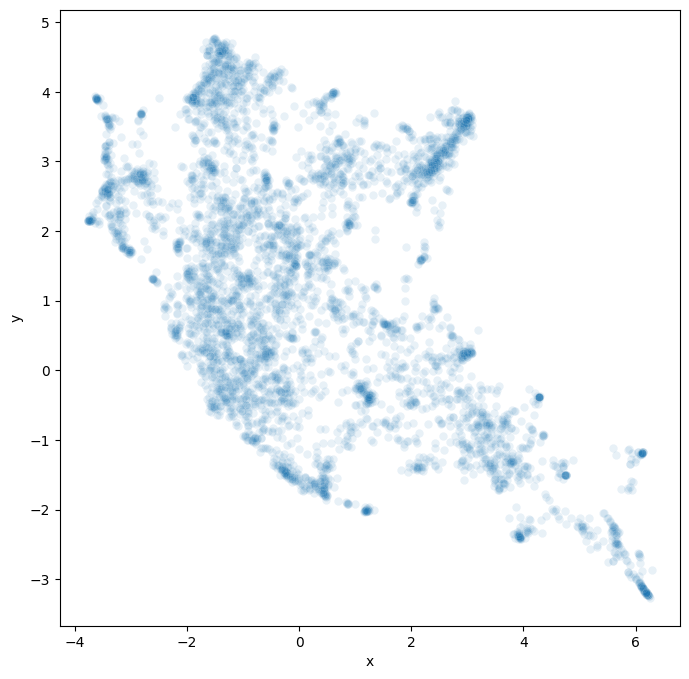

In [19]:
# visualize the dimensionality-reduced embeddings of the text

plt.figure(figsize=(8,8))
sns.scatterplot(data=vis_df, x='x', y='y', alpha=0.1)

# 4. Describe the Comments

To describe the comments, we want to do a two-step procedure: group text together by "topics" and describe those topics
- use BERTopic to group together like articles, since any given corpus of text will often feature multiple comments
- use a 'representation' layer with BERTopic to describe the different topics.
    - try out both local and API models
    - try out different forms of prompting (Q & A, summarization, etc.)

In [92]:
# Sepcify the topic modeling and summarization

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = MaximalMarginalRelevance(diversity=0.3)
)

In [93]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

In [94]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2085,-1_for_they_my_all,"[for, they, my, all, your, people, army, us, b...","[Um, no, If they want us to thank them, for t..."
1,0,507,0_and_army_for_military,"[and, army, for, military, us, your, country, ...","[The army has been the weakest it’s ever been,..."
2,1,456,1_israel_for_jews_fight,"[israel, for, jews, fight, can, israeli, all, ...","[I will not die for Israel, I will not die for..."
3,2,399,2_maxwell_your_and_what,"[maxwell, your, and, what, can, know, like, br...",[@Hoops Macabre Some people like you are incul...
4,3,285,3_russia_ukraine_russian_china,"[russia, ukraine, russian, china, we, not, rus...",[@Kevin Johnston What I will say is that there...
5,4,261,4_white_for_men_whites,"[white, for, men, whites, this, military, them...","[If you are White and join this, remember that..."
6,5,251,5_oy_shut_goy_lol,"[oy, shut, goy, lol, clown, boom, well, hi, no...","[Oy vey, they’re figuring it out.. SHUT IT DOW..."
7,6,193,6_ad_this_commercial_army,"[ad, this, commercial, army, ads, slogan, new,...",[This is a good ad. I'm glad they went back to...
8,7,174,7_zogbot_100_bankers_correct,"[zogbot, 100, bankers, correct, bot, isreal, d...","[zogbot, Zogbot, Zogbot lmao]"
9,8,134,8_comments_section_these_hope,"[comments, section, these, hope, here, bot, re...","[These comments are so based., Based comment s..."


<Axes: xlabel='x', ylabel='y'>

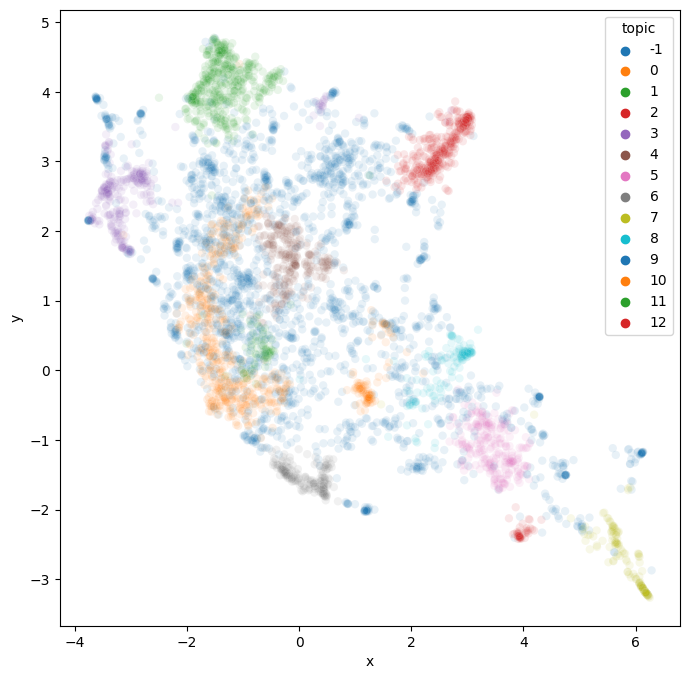

In [95]:
plt.figure(figsize=(8,8))
vis_df['topic'] = topics
sns.scatterplot(data=vis_df, x='x', y='y', hue='topic', palette='tab10', alpha=0.1)

This gives us some idea of the comments section, but we can do better. Instead of trying to guess what the major themes are in data based upon keywords, lets summarize the blocks of comments instead. To do this, we'll leverage a Large Language Model with prompting.

In [209]:
prompt = '''These texts are comments made by various users to a U.S. Army Recruiting video. Please give a brief summarization of the comments as they relate to the video.'''

In [213]:
#llm = OpenAI(temperature=0)
#llm = AzureOpenAI(deployment_name="gpt35", model_name="text-davinci-003")
llm = HuggingFacePipeline.from_model_id(model_id="declare-lab/flan-alpaca-gpt4-xl", task = 'text2text-generation', device=0,
                                      model_kwargs={"max_length":500, "no_repeat_ngram_size":2})

chain = chain = load_summarize_chain(llm, chain_type="stuff")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [214]:
# Sepcify the topic modeling and summarization

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = LangChain(chain, prompt=prompt)
)

In [215]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

Token indices sequence length is longer than the specified maximum sequence length for this model (1014 > 512). Running this sequence through the model will result in indexing errors


In [117]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1393,-1_The Army's diversity campaign is being crit...,[The Army's diversity campaign is being critic...,"[Um, no, If they want us to thank them, for t..."
1,0,1540,0_The comments discuss the lack of patriotism ...,[The comments discuss the lack of patriotism a...,[Welllllll.... I can think of a time in my own...
2,1,469,1_The US Army of Israel reassures its soldiers...,[The US Army of Israel reassures its soldiers ...,"[I will not die for Israel, I will die for Isr..."
3,2,439,2_The tweets discuss the controversy surroundi...,[The tweets discuss the controversy surroundin...,"[@The Gem don't do it man, everyone I know wh..."
4,3,291,3_The tweets discuss the role of Russia in the...,[The tweets discuss the role of Russia in the ...,"[@Ginger Licious and, yes, it’s not for you to..."
5,4,252,4_The Jewish community is urging the internet ...,[The Jewish community is urging the internet t...,"[Shut it down THE GOYIM KNOW, Oy Vey! the Goyi..."
6,5,185,5_The tweet is about a robot that is very funn...,[The tweet is about a robot that is very funny...,"[Zogbot, Zogbot, Zogbot lmao]"
7,6,152,"6_""Be all that you can, die for Be all youcan...","[""Be all that you can, die for Be all youcan ...","[Be all you can be., Be all you can’t be 😂, Be..."
8,7,131,7_The comment section is based and provides va...,[The comment section is based and provides val...,"[Based comment section, These comments are so ..."
9,8,102,8_The conversation revolves around the idea of...,[The conversation revolves around the idea of ...,[@ScuffedRyanGosling Convincing someone they h...


In [118]:
for i in topic_model.get_topic_info()['Name']:
    print(i)

-1_The Army's diversity campaign is being criticized for sugar-coating the reality of military service and for promoting diversity instead of highlighting the challenges and dangers of combat.___
0_The comments discuss the lack of patriotism among members of the US military, particularly among younger generations. Some argue that the military should focus on its core values and not on political or ideological issues. Others argue for a stronger emphasis on the Army's history and tradition, and for the need to address concerns about recruitment.___
1_The US Army of Israel reassures its soldiers that they will not die for Israel, as it is a land of opportunity for the Jewish state.___
2_The tweets discuss the controversy surrounding the "woke" movement and its impact on society.___
3_The tweets discuss the role of Russia in the Holocaust and the denial of the existence of Nazism in Europe, the Middle East, and Africa.___
4_The Jewish community is urging the internet to shut down comments

In [119]:
rep_docs = topic_model.get_representative_docs()

explanation

# 5. Zero-shot Text Classification

In [120]:
classifier = pipeline(model="facebook/bart-large-mnli", task="zero-shot-classification", device=1)

In [121]:
labels = ["supportive of service in the army", "antisemitic", "anti-ukraine", "anti-diversity", "anti-war", "anti-government", "white supremacy",
          "anti-immigration", "against service in the military", "arguing with someone", "anti-vaccination", "sexual misconduct", "neutral comment"]

In [122]:
# Screen for blank comments

comments_list = [i for i in comments_df['clean_comment'].to_list() if len(i) >0]

In [123]:
# Classify the actual comments

cls_results = classifier(comments_list, candidate_labels = labels, multi_label=True)

In [124]:
# look at some of the results
cls_results[0:3]

[{'sequence': "What will would come out with and say about the us army having contracts in relation to pathogen weapons with the Ukraine health system. The who said Ukraine health system has been under severe pressure. Pressure meaning to cause persuasion ob or intimidation. Now I've seen the leaked army document. I'm saving it to my phone. And I've sent the document to your presidents email.",
  'labels': ['anti-ukraine',
   'arguing with someone',
   'anti-government',
   'anti-war',
   'against service in the military',
   'supportive of service in the army',
   'anti-diversity',
   'antisemitic',
   'anti-vaccination',
   'white supremacy',
   'neutral comment',
   'anti-immigration',
   'sexual misconduct'],
  'scores': [0.21546143293380737,
   0.1712663173675537,
   0.16462503373622894,
   0.040081191807985306,
   0.01801249012351036,
   0.017138170078396797,
   0.013309652917087078,
   0.005149790085852146,
   0.004333734046667814,
   0.003373402403667569,
   0.00279589649289846

In [125]:
# Get out the most probable labels

zero_shot_labels = [res['labels'][np.argmax(res['scores'])] for res in cls_results]
label_counts = pd.DataFrame.from_dict(Counter(zero_shot_labels), orient='index', columns=['count'])
label_counts['label'] = label_counts.index

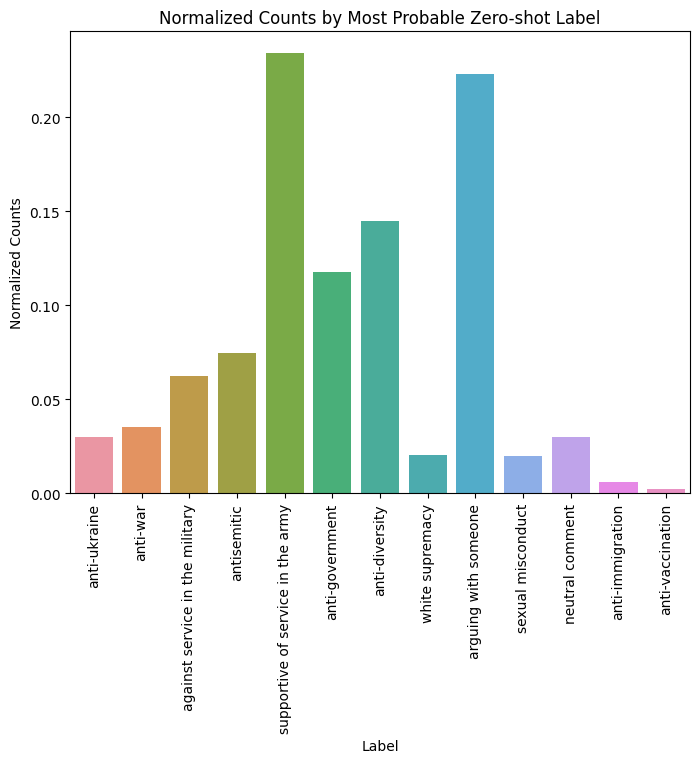

In [126]:
# Visualize the distribution of the most common labels in the comments

# Normalize the counts
label_counts['Normalized Counts'] = label_counts['count'] / label_counts['count'].sum()

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=label_counts, x='label', y='Normalized Counts')
plt.xlabel('Label')
plt.xticks(rotation=90)
plt.ylabel('Normalized Counts')
plt.title('Normalized Counts by Most Probable Zero-shot Label')
plt.show()

In [127]:
# Get the probable labels for each comment (each comment could have more than one probable label, or none)

threshold = 0.5
zero_shot_labels = [[res['labels'][i] for i in range(len(res['scores'])) if res['scores'][i] >=threshold] for res in cls_results]

# Create a set to store all unique strings in the sublists
unique_strings = set()
for sublist in zero_shot_labels:
    unique_strings.update(sublist)

# Initialize a dictionary to store the frequencies
frequencies = {string: [] for string in unique_strings}

# Count the occurrences of strings in each sublist
for sublist in zero_shot_labels:
    string_counts = {string: sublist.count(string) for string in unique_strings}
    for string, count in string_counts.items():
        frequencies[string].append(count)

# Create the dataframe
probable_labels_df = pd.DataFrame(frequencies)

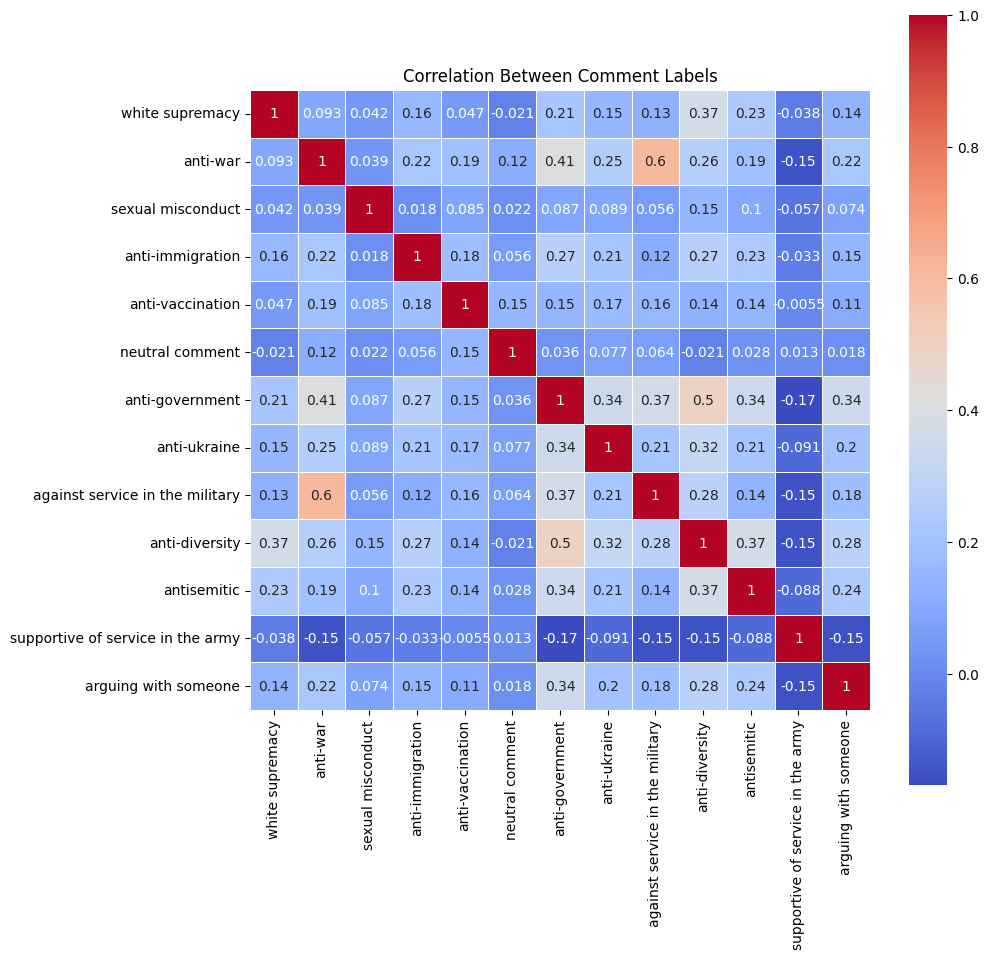

In [128]:
# Visualize the correlation between the different labels of the comments

# Calculate the point biserial correlation for each pair of columns
correlations = {}
for col1 in probable_labels_df.columns:
    for col2 in probable_labels_df.columns:
        if col1 != col2:
            corr, _ = stats.pointbiserialr(probable_labels_df[col1], probable_labels_df[col2])
            correlations[(col1, col2)] = corr

# Create a correlation matrix
corr_matrix = pd.DataFrame(index=probable_labels_df.columns, columns=probable_labels_df.columns)
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        corr_matrix.loc[col1, col2] = correlations.get((col1, col2), 1.0)


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5, square=True)
plt.title('Correlation Between Comment Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

explanation

# 6. Few-shot Prompting for Stance Classification

In [129]:
template = '''
comment: {comment}
stance: {stance}
'''

example_prompt = PromptTemplate(
    input_variables=["comment", "stance"],
    template=template
)

In [144]:
examples = [
    {'comment':rep_docs[0][2],
     'stance': 'AGAINST'},
    {'comment':rep_docs[1][1],
     'stance': 'AGAINST'},
    {'comment':rep_docs[2][2],
     'stance': 'NEUTRAL'},
    {'comment':rep_docs[4][0],
     'stance': 'AGAINST'},
    {'comment':rep_docs[6][0],
     'stance': 'FOR'}
]

In [145]:
print(example_prompt.format(**examples[0]))


comment: Hey Army, read the room. I've got a NCO buddy being asked "What can we do to improve recruiting numbers?"  What can he say? Nothing that you want to hear.   Many comments are about not wanting to fight/die for foreign/Israeli/politician wars.  Many comments are about not wanting to fight/die for a country that persecutes white males Many comments are about wokeness killing everything.  READ THE ROOM, ARMY! In 2007, your numbers were so bad you thought of reinstating the draft. I personally witnessed deceptive practices occurring then for recruiting such as providing black drill sgts "pimped out rides" to drive to show kids "You too can be gangsta" and other things like lowering standards, adjusting PT to accomodate unqualified and unfit, women for combat, etc. You have learned nothing, especially under Liberal "leadership" and college graduate "officers" leadership that we ALL KNOW "college isn't the home of patriotism".  "US Army... read the room". You want a suggestion? Her

In [153]:
prefix = """
The following are examples of the stance of a comment to a U.S. Army Recruiting Video on YouTube. Examples:
"""

suffix = '''
Now, classify each of the following comments into the possible stances of FOR, AGAINST, or NEUTRAL toward a U.S. Army Recruiting Video on YouTube. Only return the stance:

comment: {comment}
stance:
'''

few_shot_prompt_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["comment"],
    example_separator="\n"
)

In [154]:
print(few_shot_prompt_template.format(comment=comments_list[0]))


The following are examples of the stance of a comment to a U.S. Army Recruiting Video on YouTube. Examples:


comment: Hey Army, read the room. I've got a NCO buddy being asked "What can we do to improve recruiting numbers?"  What can he say? Nothing that you want to hear.   Many comments are about not wanting to fight/die for foreign/Israeli/politician wars.  Many comments are about not wanting to fight/die for a country that persecutes white males Many comments are about wokeness killing everything.  READ THE ROOM, ARMY! In 2007, your numbers were so bad you thought of reinstating the draft. I personally witnessed deceptive practices occurring then for recruiting such as providing black drill sgts "pimped out rides" to drive to show kids "You too can be gangsta" and other things like lowering standards, adjusting PT to accomodate unqualified and unfit, women for combat, etc. You have learned nothing, especially under Liberal "leadership" and college graduate "officers" leadership th

In [166]:
comments = np.random.choice(comments_list, size=20)

In [167]:
few_shot_stance_labels = [llm(few_shot_prompt_template.format(comment=x)) for x in comments]

In [168]:
sid = SentimentIntensityAnalyzer()

sentiment_labels = [sid.polarity_scores(x)['compound'] for x in comments]

In [171]:
stance_df = pd.DataFrame(zip(comments, few_shot_stance_labels, sentiment_labels), columns=['text', 'stance', 'sentiment'])

In [172]:
stance_df

,text,stance,sentiment
0,"If you truly are thinking about signing up, do...",AGAINST,0.2153
1,@Dr. Doolittle Confused about what? 39 replies...,NEUTRAL,-0.6774
2,"""America is a land of opportunity... for Israe...",NEUTRAL,0.3818
3,Hire the dude who made the PSYOP commerical,NEUTRAL,0.0000
4,"I'm not dying for Israel, Ukriane, or Taiwan. ...",AGAINST,0.0000
5,@Apocalypse Too bad the army ostracized their ...,AGAINST,-0.1779
6,I'm happy this slogan is back.... but we pay p...,NEUTRAL,-0.5267
7,"""Why are we not getting any new recruits?""",NEUTRAL,0.0000
8,"@Country Fried HVAC Yes, there were. Have you ...",NEUTRAL,0.7236
9,"Not anymore, be all you can be 🇺🇸🇺🇸🇺🇸",FOR,0.0000


In [180]:
stance_df.iloc[18,0]

"Support and defend degenerate politicians' over seas interests. Be all you can be for Washington D.C."

# Addendum

### Option 1

In [96]:
prompt = """
I have collection of YouTube comments to a U.S. Army Recruiting video that contains the following comments: \n[DOCUMENTS]
The collection is described by the following keywords: [KEYWORDS]

Based on the above information, can you give a brief descriprion of the collection?
"""

In [97]:
generator = pipeline(model="declare-lab/flan-alpaca-gpt4-xl", max_length=500, no_repeat_ngram_size=2, device=0)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [98]:
# Sepcify the topic modeling and summarization

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = [MaximalMarginalRelevance(diversity=0.3), TextGeneration(generator, prompt=prompt)]
)

In [99]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

In [100]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1578,-1_The collection of YouTube comments is a res...,[The collection of YouTube comments is a respo...,[@SEnergy Except the US didn't annex any of th...
1,0,1121,0_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,"[""BE ALL YOU CAN BE"" was, is and always will b..."
2,1,446,1_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,"[I will not die for Israel, I will die for Isr..."
3,2,421,2_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,"[@The Gem don't do it man, everyone I know wh..."
4,3,326,3_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,[They hate your for being White but they want ...
5,4,314,4_The collection of YouTube comments discusses...,[The collection of YouTube comments discusses ...,[@Андрей Власов Neat. How does that justify Ru...
6,5,241,5_The collection of YouTube comments contains ...,[The collection of YouTube comments contains o...,"[Shut it down THE GOYIM KNOW, Oy Vey! the Goyi..."
7,6,165,6_The collection of YouTube comments contains ...,[The collection of YouTube comments contains j...,"[Zogbot, zogbot, Zogbot lmao]"
8,7,135,7_The collection of YouTube comments is relate...,[The collection of YouTube comments is related...,"[These comments are so based., Based comment s..."
9,8,104,8_The collection of YouTube comments contains ...,[The collection of YouTube comments contains m...,"[Be All You Can Be!, Be all you can be., Be al..."


In [101]:
for i in topic_model.get_topic_info()['Name']:
    print(i)

-1_The collection of YouTube comments is a response to 'This was so gay.', expressing disapproval towards the use of the word woke in the video. The comments also discuss the reality of being in an Army, which is not always clean and involves struggles and death.___
0_The collection of YouTube comments is a response to promoting the U.S. Army's recruitment video. Some of the comments are critical of its message, highlighting the sacrifice of Marines who died in combat. Others praise the Army for its slogan, "BE ALL YOU CAN BE," and compare the previous "WOKE" commercial to an embarrassment. The last comment, which references Soros and the WEF, suggests that surviving the military is an act of betrayal of one'' country. Overall, the collection expresses varying opinions on the effectiveness of Army recruitment efforts and their potential to promote patriotism and unity.___
1_The collection of YouTube comments is a response to 'Be All You Can Be (For Israel)', referring to the U.S. Army 

### Option 2

In [108]:
prompt = '''These texts are comments about a U.S. Army Recruiting video. What is the theme of these comments? Please give a brief description.'''

In [103]:
# llm = OpenAI(temperature=0)
llm = HuggingFacePipeline.from_model_id(model_id="declare-lab/flan-alpaca-gpt4-xl", task = 'text2text-generation', device=0,
                                       model_kwargs={"max_length":500, "no_repeat_ngram_size":2})

chain = load_qa_chain(llm=llm, chain_type="stuff")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [109]:
# Sepcify the topic modeling and summarization

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = LangChain(chain, prompt=prompt)
)

In [110]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

In [111]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1610,-1_The theme of these comments is the U.S. Arm...,[The theme of these comments is the U.S. Army ...,[​​​@Justin Williams I get where you're coming...
1,0,1161,0_The theme of these comments is disapproval a...,[The theme of these comments is disapproval an...,"[So they remove ""that"" It used to be: Be, all..."
2,1,455,1_The theme of these comments is support for t...,[The theme of these comments is support for th...,"[I will not die for Israel, I will not die for..."
3,2,407,2_The theme of these comments is disapproval a...,[The theme of these comments is disapproval an...,"[@The Gem don't do it man, everyone I know wh..."
4,3,374,3_The theme of these comments is anti-military...,[The theme of these comments is anti-military ...,[It's in jest. The US Army is trying to pull ...
5,4,284,4_The theme of these comments is anti-Russian ...,[The theme of these comments is anti-Russian s...,[​​@I Stand With Russia (Z O V) Do you actuall...
6,5,244,5_The theme of these comments is anti-Semitism...,[The theme of these comments is anti-Semitism ...,"[The goyim know, shut it down., Oy Vey! the Go..."
7,6,161,6_The theme of these comments is humor and sup...,[The theme of these comments is humor and supp...,"[Zogbot, Zogbot, Zogbot lmao]"
8,7,109,7_The theme of these comments is helpful.___,"[The theme of these comments is helpful., , , ...","[These comments are so based., Based comment s..."
9,8,106,"8_The theme of these comments is ""Believe in y...","[The theme of these comments is ""Believe in yo...","[Be all you can be., Be All You Can Be!, Be al..."


In [112]:
for i in topic_model.get_topic_info()['Name']:
    print(i)

-1_The theme of these comments is the U.S. Army Recruiting video.___
0_The theme of these comments is disapproval and rejection of the U.S. Army's recruitment efforts.___
1_The theme of these comments is support for the U.S. Army and its mission to protect and defend Israel.___
2_The theme of these comments is disapproval and criticism of the U.S. Army Recruiting video.___
3_The theme of these comments is anti-military recruitment and the exodus of white males from the U.S. Army.___
4_The theme of these comments is anti-Russian sentiment and antisemitism.___
5_The theme of these comments is anti-Semitism and antipathy towards the Jewish community.___
6_The theme of these comments is humor and support for the U.S. Army Recruiting video.___
7_The theme of these comments is helpful.___
8_The theme of these comments is "Believe in yourself and your abilities."___
9_The theme of these comments is anti-government and anti Trump protests.___
10_The theme of these comments is criticism of the 